In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import warnings
import datetime
from lightgbm import LGBMRegressor
from chinese_calendar import is_workday
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
import joblib
warnings.filterwarnings("ignore")

In [2]:
## 读取之前处理好的原数据：


pd.options.display.max_columns=100 # to see columns 
df = pd.read_csv('../以周粒度预测/data/proess_transform.csv',encoding='utf-8')  #读取之前周预测时的那个原数据
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,价格区间,每月时间段,season_bm,星期几,is_workday,W
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,4,0,2,1,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,4,0,2,1,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,0,0,2,2,1,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,3,0,2,2,1,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,5,0,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597356,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,3,1,3,3,1,173
597357,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,2,1,3,3,1,173
597358,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,6,1,3,3,1,173
597359,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,6,1,3,3,1,173


In [3]:
df.drop(['W'],axis=1,inplace=True)
df 
    

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597356,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,3,1,3,3,1
597357,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,2,1,3,3,1
597358,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,6,1,3,3,1
597359,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,6,1,3,3,1


# 构造M列，月

In [4]:
beginDate_01 = '2015-09-01'
endDate = '2019-01-31'


date_index_01 = pd.date_range(beginDate_01, endDate)
days_01 = [pd.Timestamp(x).strftime("%Y-%m-%d") for x in date_index_01.values]
days_01

tmp_one_01 = []
sum = 1
for index , v in enumerate(days_01):

    if days_01[index].split("-")[2] =='01':
        tmp_one_01.append([sum,days_01[index]])
        sum+=1
        
print(tmp_one_01)

[[1, '2015-09-01'], [2, '2015-10-01'], [3, '2015-11-01'], [4, '2015-12-01'], [5, '2016-01-01'], [6, '2016-02-01'], [7, '2016-03-01'], [8, '2016-04-01'], [9, '2016-05-01'], [10, '2016-06-01'], [11, '2016-07-01'], [12, '2016-08-01'], [13, '2016-09-01'], [14, '2016-10-01'], [15, '2016-11-01'], [16, '2016-12-01'], [17, '2017-01-01'], [18, '2017-02-01'], [19, '2017-03-01'], [20, '2017-04-01'], [21, '2017-05-01'], [22, '2017-06-01'], [23, '2017-07-01'], [24, '2017-08-01'], [25, '2017-09-01'], [26, '2017-10-01'], [27, '2017-11-01'], [28, '2017-12-01'], [29, '2018-01-01'], [30, '2018-02-01'], [31, '2018-03-01'], [32, '2018-04-01'], [33, '2018-05-01'], [34, '2018-06-01'], [35, '2018-07-01'], [36, '2018-08-01'], [37, '2018-09-01'], [38, '2018-10-01'], [39, '2018-11-01'], [40, '2018-12-01'], [41, '2019-01-01']]


In [5]:
M= []
for li in df['订单日期']:
    for i in range(len(tmp_one_01)):
        if tmp_one_01[i][1]=='2019-01-01' and li>=tmp_one_01[i][1]:
#             print(tmp_one_01[i][0])
            M.append(tmp_one_01[i][0])
            break
    
        if li >= tmp_one_01[i][1] and li<tmp_one_01[i+1][1]:
#             print(tmp_one_01[i][0])
            M.append(tmp_one_01[i][0])
M

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [6]:
df['M'] = M
df


,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,价格区间,每月时间段,season_bm,星期几,is_workday,M
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,4,0,2,1,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,4,0,2,1,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,0,0,2,2,1,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,3,0,2,2,1,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,5,0,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597356,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,3,1,3,3,1,40
597357,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,2,1,3,3,1,40
597358,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,6,1,3,3,1,40
597359,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,6,1,3,3,1,40


In [7]:
df.to_csv("../以月粒度预测/data/proess_transform.csv",index=False)  #保存数据，用于后续预测出19-01年数据后进行拼接，将19-01月数据添加在这个数据后
#作为训练集。再去预测19-02月的数据。

OSError: Cannot save file into a non-existent directory: '..\以月粒度预测\data'

# 构造待预测的19年1月  周数据

这里跟以天为粒度预测是一样的操作，借助日期，只是不同点是构造W列，而不是D列了

In [ ]:
temp = df[df['销售区域编码']!=104]
temp #减少了2w多数据

In [ ]:
temp['zuhe'] = temp['销售区域编码'].astype(str)+'_'+temp['产品大类编码'].astype(str)+'_'+temp['产品细类编码'].astype(str)+'_'+temp['产品编码'].astype(str)
temp
len(set(temp['zuhe']))

In [ ]:
#从2018-12-21到2019-1-31日的数据

dt1 = pd.date_range(start="20181221", end="20190131", freq="D")
dt1
# len(dt1)
dates=[]
need=[]
ids =[]
for d in dt1:
    date = str(d).split(' ')[0] #得到日期xx-xx-xx
    dates=dates+[date]*len(set(temp['zuhe']))
    need = need+[0]*len(set(temp['zuhe']))
    ids=ids+list(set(temp['zuhe']))
tempdf=pd.DataFrame()
tempdf['订单日期']=dates
tempdf['zuhe']=ids
tempdf['订单需求量']=need
tempdf  

In [ ]:
## chu处理tempdf为df的数据格式：

tempdf['销售区域编码']=tempdf['zuhe'].str.split('_',expand=True)[0]
tempdf['产品大类编码']=tempdf['zuhe'].str.split('_',expand=True)[1]
tempdf['产品细类编码']=tempdf['zuhe'].str.split('_',expand=True)[2]
tempdf['产品编码']=tempdf['zuhe'].str.split('_',expand=True)[3]
tempdf
import chinese_calendar
import datetime

tempdf['订单日期'] = pd.to_datetime(tempdf['订单日期'])  #对日期列进行日期格式转换
tempdf['Year'] = tempdf.订单日期.dt.year #分解出年份
tempdf['Month'] = tempdf.订单日期.dt.month
tempdf['day'] = tempdf.订单日期.dt.day

tempdf

import datetime
from chinese_calendar import is_holiday, is_workday
is_holidays =[]  #用来存放日期是否为节假日。1为是，0为不是
for index,row in tempdf.iterrows():
    day = datetime.date(int(row['Year']), int(row['Month']),int(row['day']))
    if is_holiday(day):
        is_holidays.append(1)
    else:
        is_holidays.append(0)
tempdf['是否节假日'] = is_holidays  #加入到表格汇总
tempdf

## 去掉104区域的产品，我们构造的待预测的数据集，从225372 降为214578  

#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in tempdf.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


tempdf['是否促销日']=cuxs
tempdf

In [ ]:
##映射产品价格区间：：：
jagdf=temp[['zuhe','价格区间','销售渠道名称']]
jagdf.drop_duplicates(['zuhe'],keep='last',inplace=True)
jagdf
dict_jg = {}
qudao_dict={}
for i in range(len(jagdf)):
    dict_jg[list(jagdf['zuhe'])[i]]=list(jagdf['价格区间'])[i]
    qudao_dict[list(jagdf['zuhe'])[i]] = list(jagdf['销售渠道名称'])[i]
dict_jg
qudao_dict
#价格区间：
jiage=[]
qudao =[]
for v in tempdf['zuhe']:
    jiage.append(dict_jg[v])
    qudao.append(qudao_dict[v])
tempdf['价格区间']=jiage
tempdf['销售渠道名称']=qudao

del jagdf,dict_jg,qudao_dict#用完就删，减少内存开销

tempdf


In [ ]:
'''
处理月中、月末等、季节：
'''

tempdf['标签'] = "空"


for index,row in tempdf.iterrows():
    ts = pd.Timestamp(row['Year'],row['Month'],row['day'])
    end=ts+pd.offsets.MonthEnd()
    if row['订单日期'] < pd.to_datetime(end) and row['订单日期'] <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],10)):
        tempdf.at[index,'标签'] = "月初"
    elif pd.to_datetime(pd.Timestamp(row['Year'], row['Month'],10))< row['订单日期']  <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],20)):
        tempdf.at[index,'标签'] = "月中" 
    else:
        tempdf.at[index,'标签'] = "月末" 
                        
tempdf

tempdf["season"] = tempdf["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})

dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
tempdf['season_bm'] =tempdf.season.map(dict_season)
tempdf
dict_moth = {'月初':0,'月中':1,'月末':2}
tempdf['每月时间段'] =tempdf.标签.map(dict_moth)
tempdf

In [ ]:
tempdf['星期几'] = tempdf.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}

tempdf['is_workday']=tempdf['订单日期'].map(lambda x:is_workday(x))

dict_is_workday = {False:0,True:1}
tempdf['is_workday'] =tempdf.is_workday.map(dict_is_workday)
tempdf

In [ ]:
tempdf.drop(['标签','season','zuhe'],axis=1,inplace=True)
tempdf

In [ ]:
### 构造19年1月的M列：
tempdf['订单日期'] = tempdf['订单日期'].astype('str')  #先修改一下类型为str
M= []
for li in tempdf['订单日期']:
    for i in range(len(tmp_one_01)):
        if tmp_one_01[i][1]=='2019-01-01' and li>=tmp_one_01[i][1]:
#             print(tmp_one_01[i][0])
            M.append(tmp_one_01[i][0])
            break
    
        if li >= tmp_one_01[i][1] and li<tmp_one_01[i+1][1]:
#             print(tmp_one_01[i][0])
            M.append(tmp_one_01[i][0])
M
tempdf['M'] = M
tempdf

In [ ]:
df_sub=tempdf[['订单日期', '销售区域编码', '产品编码', '产品大类编码', '产品细类编码', '销售渠道名称', '订单需求量', 'Year',
       'Month', 'day', '是否节假日', '是否促销日', '价格区间', '每月时间段', 'season_bm',
       '星期几', 'is_workday','M']]
del tempdf
df_sub

In [ ]:
df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]] = df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]].apply(pd.to_numeric)
df_sub['价格区间']=df_sub['价格区间'].astype('category')
df_sub.info()

In [ ]:
#拼接df_sub和df：

df1 =pd.concat([df,df_sub],axis=0)
df1

In [ ]:
DF = df1[df1['M']>=40]
# b保存一下构造的19年1月数据：
DF.to_csv('../以周粒度预测/data/构造19_01data.csv',index=False,)  #因为在2018-12-20日到2018-12-31，也是属于第40月，
#                                                                   所以为了后面将预测的数据放入构造好的数据时不报错，
#                                                                    所以多选了几天的数据放入构造数据中。

In [ ]:
del df #将原数据的df释放掉

df = df1  #将拼接后的df1重新付给df
del df1 #再释放掉df1


In [ ]:
df = df.reset_index(drop=True)
df 

# 特征工程

## 均值编码

In [ ]:
df['产品编码_avg'] = df.groupby('产品编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_need_avg'] = df.groupby('销售区域编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_need_avg'] = df.groupby('产品大类编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_need_avg'] = df.groupby('产品细类编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_need_avg'] = df.groupby('销售渠道名称')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品编码_need_avg'] = df.groupby(['产品编码','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品编码_need_avg'] = df.groupby(['产品大类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_产品编码_need_avg'] = df.groupby(['产品细类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品编码_need_avg'] = df.groupby(['销售渠道名称','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品大类编码_need_avg'] = df.groupby(['销售区域编码','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品细类编码_need_avg'] = df.groupby(['产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品细类编码_need_avg'] = df.groupby(['销售渠道名称','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)



df['年_月_need_avg'] = df.groupby(['Year','Month'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售区域编码_need_avg'] = df.groupby(['Year','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品大类编码_need_avg'] = df.groupby(['Year','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品细类编码_need_avg'] = df.groupby(['Year','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售渠道名称_need_avg'] = df.groupby(['Year','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['M_销售区域编码_need_avg'] = df.groupby(['M','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['M_产品大类编码_need_avg'] = df.groupby(['M','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['M_产品细类编码_need_avg'] = df.groupby(['M','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['M_销售渠道名称_need_avg'] = df.groupby(['M','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['每月时间段_销售区域编码_need_avg'] = df.groupby(['销售区域编码','每月时间段'])['订单需求量'].transform('mean').astype(np.float16)

df['价格区间_销售区域编码_need_avg'] = df.groupby(['销售区域编码','价格区间'])['订单需求量'].transform('mean').astype(np.float16)

df['M_产品细类编码_need_avg'] = df.groupby(['产品细类编码','M'])['订单需求量'].transform('mean').astype(np.float16)


In [ ]:
df

## 滑动窗口统计

In [ ]:
df['rolling_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.rolling(window=30).mean()).astype(np.float16)

In [ ]:
df['expanding_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.expanding(15).mean()).astype(np.float16)

##  需求量趋势构建

In [ ]:
df['M_avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码','M'])['订单需求量'].transform('mean').astype(np.float16)
df['avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['M_trend'] = (df['M_avg_need'] - df['avg_need']).astype(np.float16)
df.drop(['M_avg_need','avg_need'],axis=1,inplace=True)

In [ ]:
df.drop('订单日期',axis=1,inplace=True)
df 

## 保存数据

In [ ]:
df.to_pickle('data1_Month.pkl')
del df

# 建立模型

In [8]:
data = pd.read_pickle('data1_Month.pkl')
data

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,价格区间,每月时间段,season_bm,星期几,is_workday,M,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,M_销售区域编码_need_avg,M_产品大类编码_need_avg,M_产品细类编码_need_avg,M_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,M_trend
0,104,22069,307,403,0,19,2015,9,1,0,0,4,0,2,1,1,1,12.289062,94.5625,83.50000,83.50000,61.0625,12.289062,12.289062,12.289062,12.664062,102.8750,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,100.5,105.8750,105.8750,101.8125,92.62500,61.28125,NaN,NaN,-2.953125
1,104,20028,301,405,0,12,2015,9,1,0,0,4,0,2,1,1,1,1.041992,94.5625,62.34375,62.34375,61.0625,9.000000,1.041992,1.041992,1.041992,86.8125,62.34375,37.59375,107.6875,111.0625,84.4375,84.4375,106.00,100.5,89.8125,89.8125,101.8125,92.62500,61.28125,NaN,NaN,0.000000
2,104,21183,307,403,1,109,2015,9,2,0,0,0,0,2,2,1,1,116.625000,94.5625,83.50000,83.50000,85.0625,130.125000,116.625000,116.625000,133.625000,102.8750,83.50000,91.31250,107.6875,111.0625,116.6250,116.6250,153.25,100.5,105.8750,105.8750,138.5000,92.62500,120.18750,NaN,NaN,20.375000
3,104,20448,308,404,1,3,2015,9,2,0,0,3,0,2,2,1,1,75.562500,94.5625,86.75000,86.75000,85.0625,100.500000,75.562500,75.562500,75.562500,102.5000,86.75000,94.25000,107.6875,111.0625,138.2500,138.2500,153.25,100.5,113.4375,113.4375,138.5000,92.62500,91.68750,NaN,NaN,55.625000
4,104,21565,307,403,0,3,2015,9,2,0,0,5,0,2,2,1,1,10.710938,94.5625,83.50000,83.50000,61.0625,10.710938,10.710938,10.710938,12.164062,102.8750,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,100.5,105.8750,105.8750,101.8125,92.62500,68.18750,NaN,NaN,-5.460938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,102,20176,307,403,1,0,2019,1,31,0,0,2,2,3,3,1,41,19.890625,64.5625,83.50000,83.50000,85.0625,2.765625,19.890625,19.890625,27.375000,78.5000,83.50000,91.31250,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.0000,0.0000,0.0000,56.93750,89.87500,0.0,2.765625,-2.765625
811935,105,21089,306,407,1,0,2019,1,31,0,0,2,2,3,3,1,41,46.250000,64.7500,85.87500,81.12500,85.0625,6.773438,46.250000,46.250000,1.106445,75.9375,81.12500,90.68750,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.0000,0.0000,0.0000,57.21875,67.25000,0.0,6.773438,-6.773438
811936,105,21105,308,404,0,0,2019,1,31,0,0,5,2,3,3,1,41,5.500000,64.7500,86.75000,86.75000,61.0625,9.492188,5.500000,5.500000,0.565430,72.5000,86.75000,82.81250,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.0000,0.0000,0.0000,57.21875,43.15625,0.0,9.492188,-9.492188
811937,101,20859,306,407,0,0,2019,1,31,0,0,0,2,3,3,1,41,184.125000,68.1875,85.87500,81.12500,61.0625,233.625000,184.125000,184.125000,185.000000,86.6250,81.12500,78.43750,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.0000,0.0000,0.0000,60.28125,128.00000,0.0,233.625000,-233.625000


In [9]:

valid = data[(data['M']>=39) & (data['M']<40)][['产品编码','M','订单需求量']]
test = data[data['M']>=40][['产品编码','M','订单需求量']]   #作为待预测的数据
eval_preds = test['订单需求量']    ## 待预测 目前全为0
valid_preds = valid['订单需求量']  #这是已有真实标签需求量13周数据

In [10]:
test

,产品编码,M,订单需求量
581752,21795,40,10
581753,21467,40,10
581754,21619,40,3
581755,20215,40,3
581756,21330,40,2
...,...,...,...
811934,20176,41,0
811935,21089,41,0
811936,21105,41,0
811937,20859,41,0


In [11]:
states = list(set(data['销售区域编码']))
states

[101, 102, 103, 104, 105]

In [12]:
# 画出损失函数的变化情况
def plot_logloss(model,model_name):
    results = model.evals_result_
#     print(results)
    epochs = len(results['training']['rmse'])
    x_axis = range(0, epochs)
#     print(epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['rmse'], label='训练集')
#     print(results['validation_1']['logloss'])
    ax.plot(x_axis, results['valid_1']['rmse'], label='测试集')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('{}LightGBM RMSE'.format(model_name))
    plt.savefig('{}LightGBM rmse'.format(model_name),dpi=200)
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['mape'], label='训练集')
    ax.plot(x_axis, results['valid_1']['mape'], label='测试集')
    ax.legend()
    plt.ylabel('MAPE')
    plt.title('{}LightGBM MAPE'.format(model_name))
    plt.savefig('{}LightGBM mape'.format(model_name),dpi=200)
    plt.show()

180181
*****Prediction for 销售区域: 101*****
[10]	training's rmse: 176.93	training's mape: 3.23912	training's l2: 31304.4	valid_1's rmse: 123.525	valid_1's mape: 3.80208	valid_1's l2: 15258.4
[20]	training's rmse: 175.477	training's mape: 3.11757	training's l2: 30792.2	valid_1's rmse: 123.301	valid_1's mape: 3.69369	valid_1's l2: 15203.1
[30]	training's rmse: 174.505	training's mape: 3.09855	training's l2: 30452	valid_1's rmse: 123.193	valid_1's mape: 3.69847	valid_1's l2: 15176.5


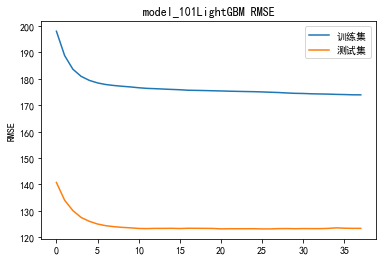

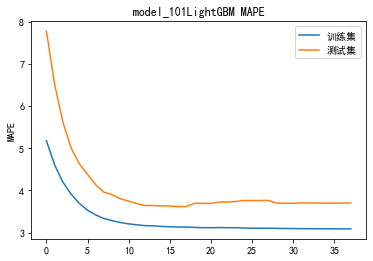

216406
*****Prediction for 销售区域: 102*****
[10]	training's rmse: 131.629	training's mape: 2.7852	training's l2: 17326.3	valid_1's rmse: 115.244	valid_1's mape: 2.80935	valid_1's l2: 13281.1
[20]	training's rmse: 130.522	training's mape: 2.65604	training's l2: 17036	valid_1's rmse: 114.813	valid_1's mape: 2.6775	valid_1's l2: 13182
[30]	training's rmse: 129.793	training's mape: 2.61288	training's l2: 16846.3	valid_1's rmse: 114.915	valid_1's mape: 2.63624	valid_1's l2: 13205.5
[40]	training's rmse: 129.095	training's mape: 2.58776	training's l2: 16665.6	valid_1's rmse: 115.084	valid_1's mape: 2.6355	valid_1's l2: 13244.4


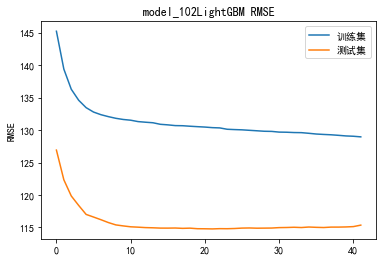

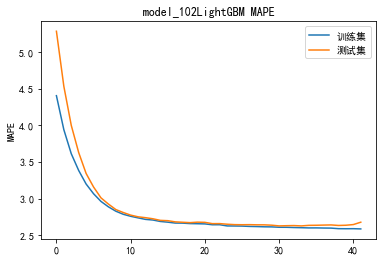

166828
*****Prediction for 销售区域: 103*****
[10]	training's rmse: 172.818	training's mape: 3.10509	training's l2: 29866.2	valid_1's rmse: 152.665	valid_1's mape: 4.04914	valid_1's l2: 23306.7
[20]	training's rmse: 171.011	training's mape: 2.97065	training's l2: 29244.8	valid_1's rmse: 151.821	valid_1's mape: 3.81359	valid_1's l2: 23049.6
[30]	training's rmse: 170.247	training's mape: 2.96121	training's l2: 28984	valid_1's rmse: 151.56	valid_1's mape: 3.83731	valid_1's l2: 22970.6
[40]	training's rmse: 169.067	training's mape: 2.94036	training's l2: 28583.5	valid_1's rmse: 151.688	valid_1's mape: 3.78794	valid_1's l2: 23009.3
[50]	training's rmse: 168.101	training's mape: 2.92188	training's l2: 28258	valid_1's rmse: 152.039	valid_1's mape: 3.78477	valid_1's l2: 23116


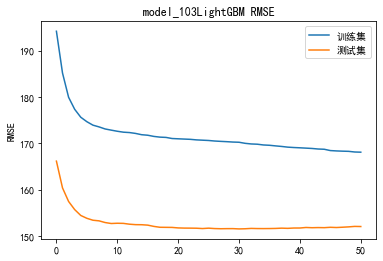

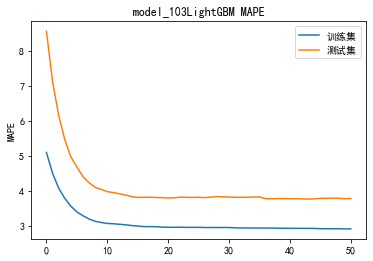

25053
*****Prediction for 销售区域: 104*****
223471
*****Prediction for 销售区域: 105*****
[10]	training's rmse: 166.263	training's mape: 3.31524	training's l2: 27643.4	valid_1's rmse: 171.477	valid_1's mape: 4.16315	valid_1's l2: 29404.3
[20]	training's rmse: 164.109	training's mape: 3.19113	training's l2: 26931.8	valid_1's rmse: 171.813	valid_1's mape: 4.09909	valid_1's l2: 29519.7


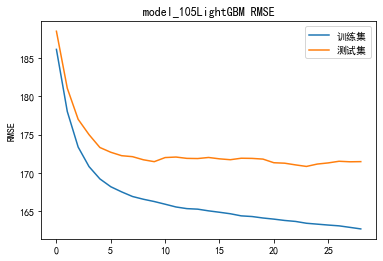

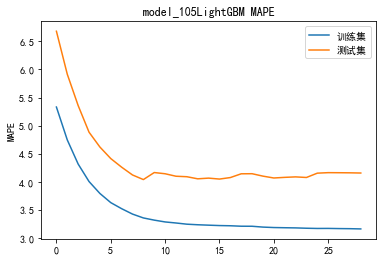

In [13]:
for store in states:
    try:
        df = data[data['销售区域编码']==store]
        print(len(df))

        #Split the data
        X_train, y_train = df[df['M']<39].drop('订单需求量',axis=1), df[df['M']<39]['订单需求量']
        X_valid, y_valid = df[(df['M']>=39) & (df['M']<40)].drop('订单需求量',axis=1), df[(df['M']>=39) & (df['M']<40)]['订单需求量']
        X_test = df[df['M']>=40].drop('订单需求量',axis=1)

        #Train and validate
        model = LGBMRegressor( 
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for 销售区域: {}*****'.format(store))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse,mape', verbose=10, early_stopping_rounds=20)
        valid_preds[X_valid.index] = model.predict(X_valid)
        eval_preds[X_test.index] = model.predict(X_test)
        filename = "models/" + "model_"+ str(store) + ".pkl"
        # save model
        joblib.dump(model, filename)
#         print("ces:",model.evals_result_)
        plot_logloss(model,"model_"+ str(store))
   
        del model, X_train, y_train, X_valid, y_valid
    except:
        del model, X_train, y_train, X_valid, y_valid
        continue

## 挑选出101区域的模型进行模型验证

In [36]:
model = joblib.load("models/model_101.pkl")
model

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=8,
              min_child_weight=300, n_estimators=1000, num_leaves=50,
              subsample=0.8)

In [37]:
df = data[data['销售区域编码']==101]
X_valid, y_valid = df[(df['M']>=39) & (df['M']<40)].drop('订单需求量',axis=1), df[(df['M']>=39) & (df['M']<40)]['订单需求量']
y_valid
s = model.predict(X_valid)
s

array([ 20.91134265,  53.88643473, 108.2096616 , ..., 237.2317085 ,
        13.1671507 ,  74.5941188 ])

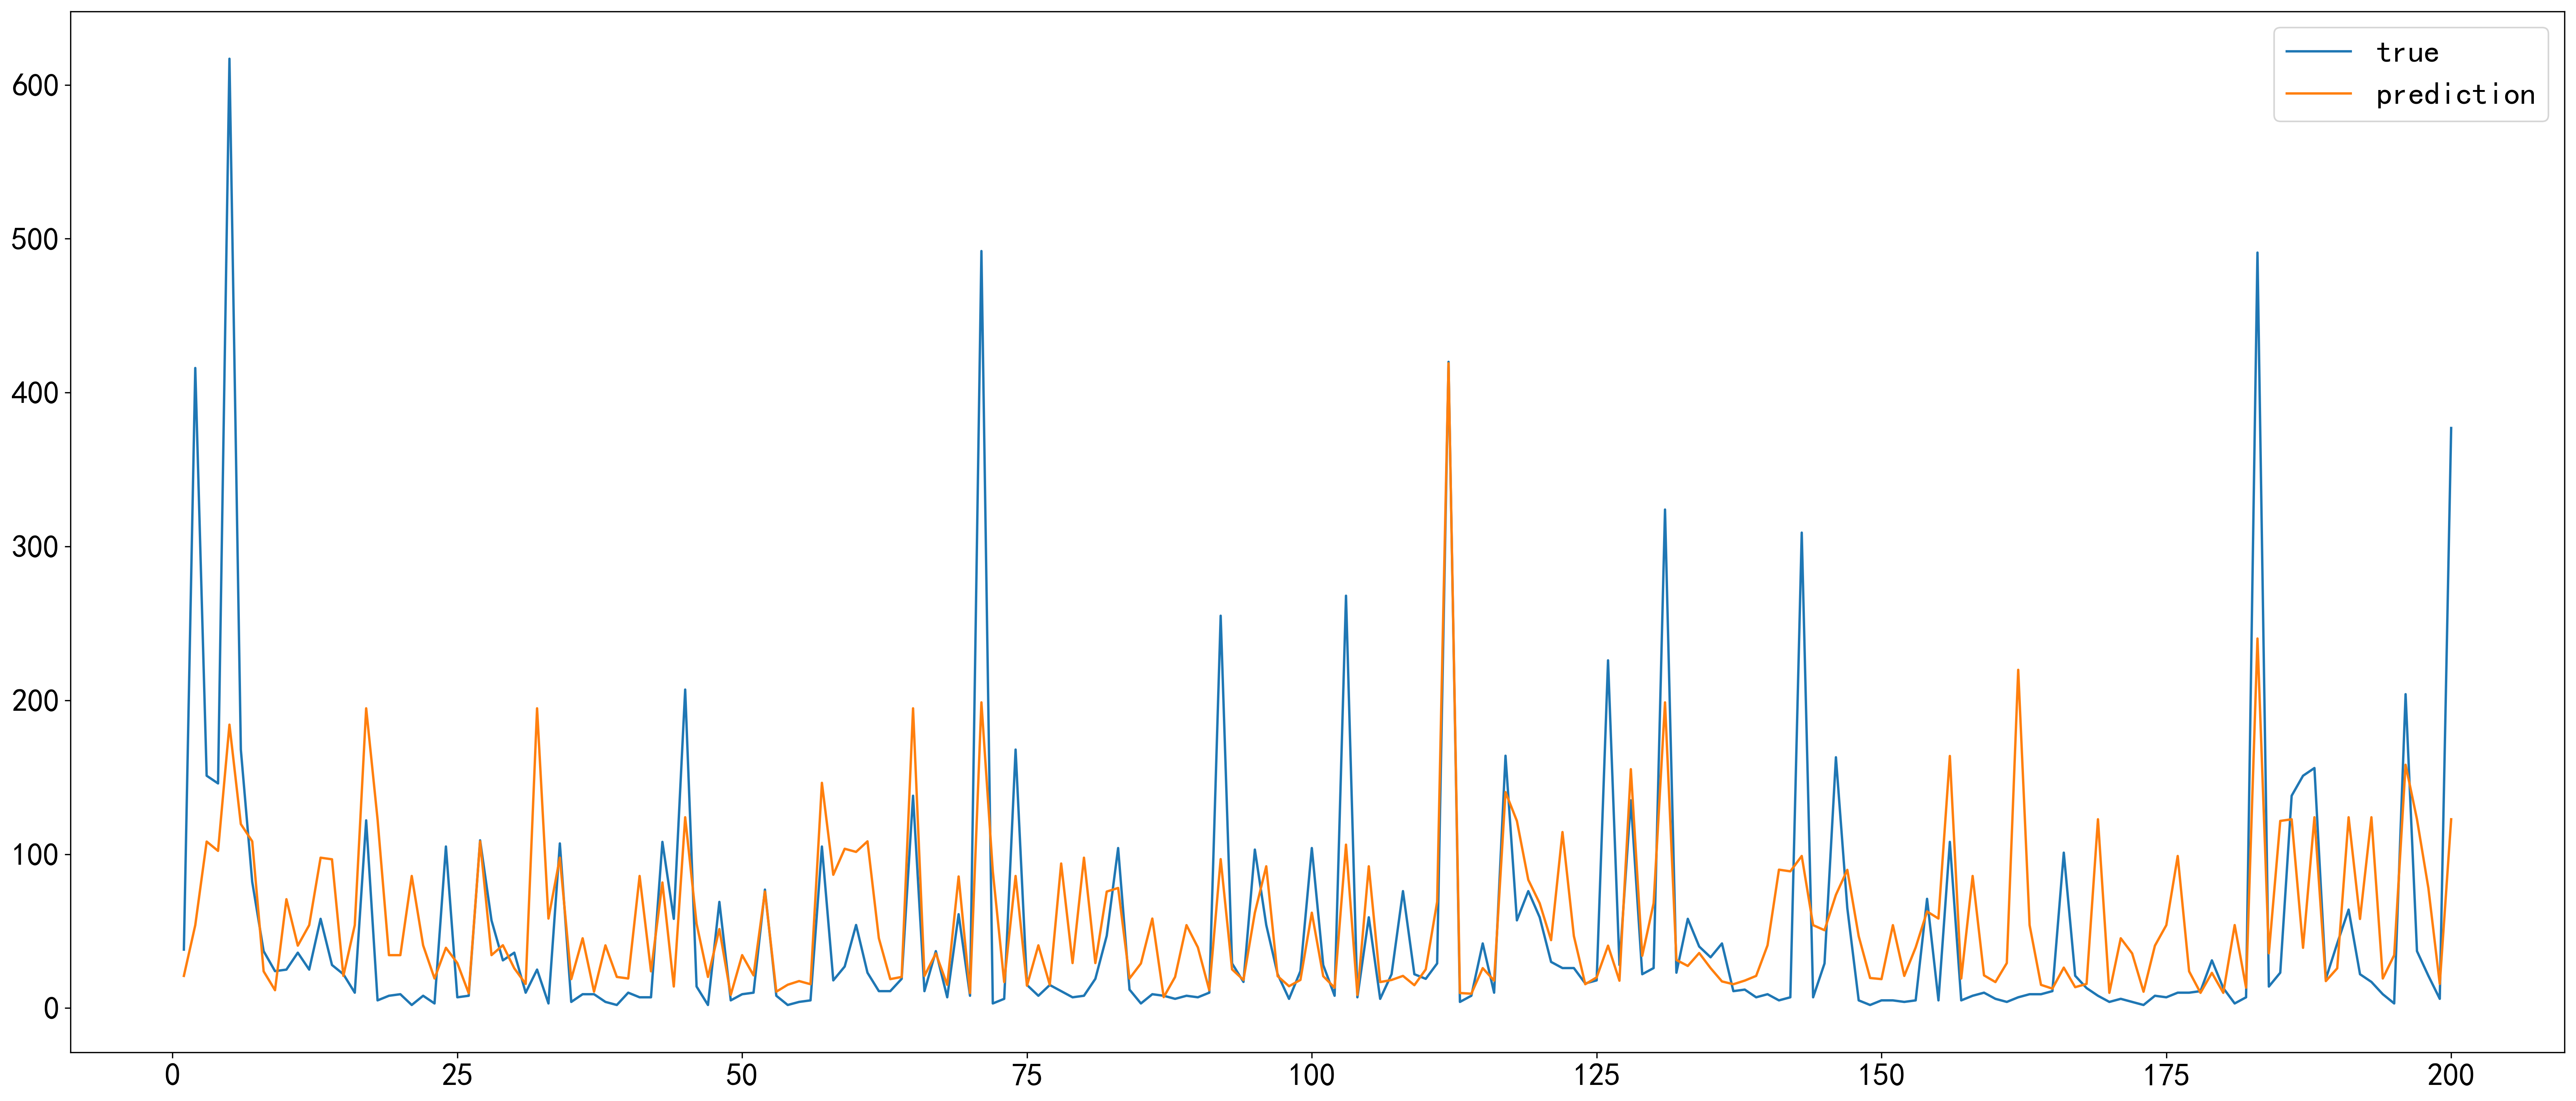

In [38]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:200],y_valid[:200])
plt.plot(x_axis[:200],s[:200])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

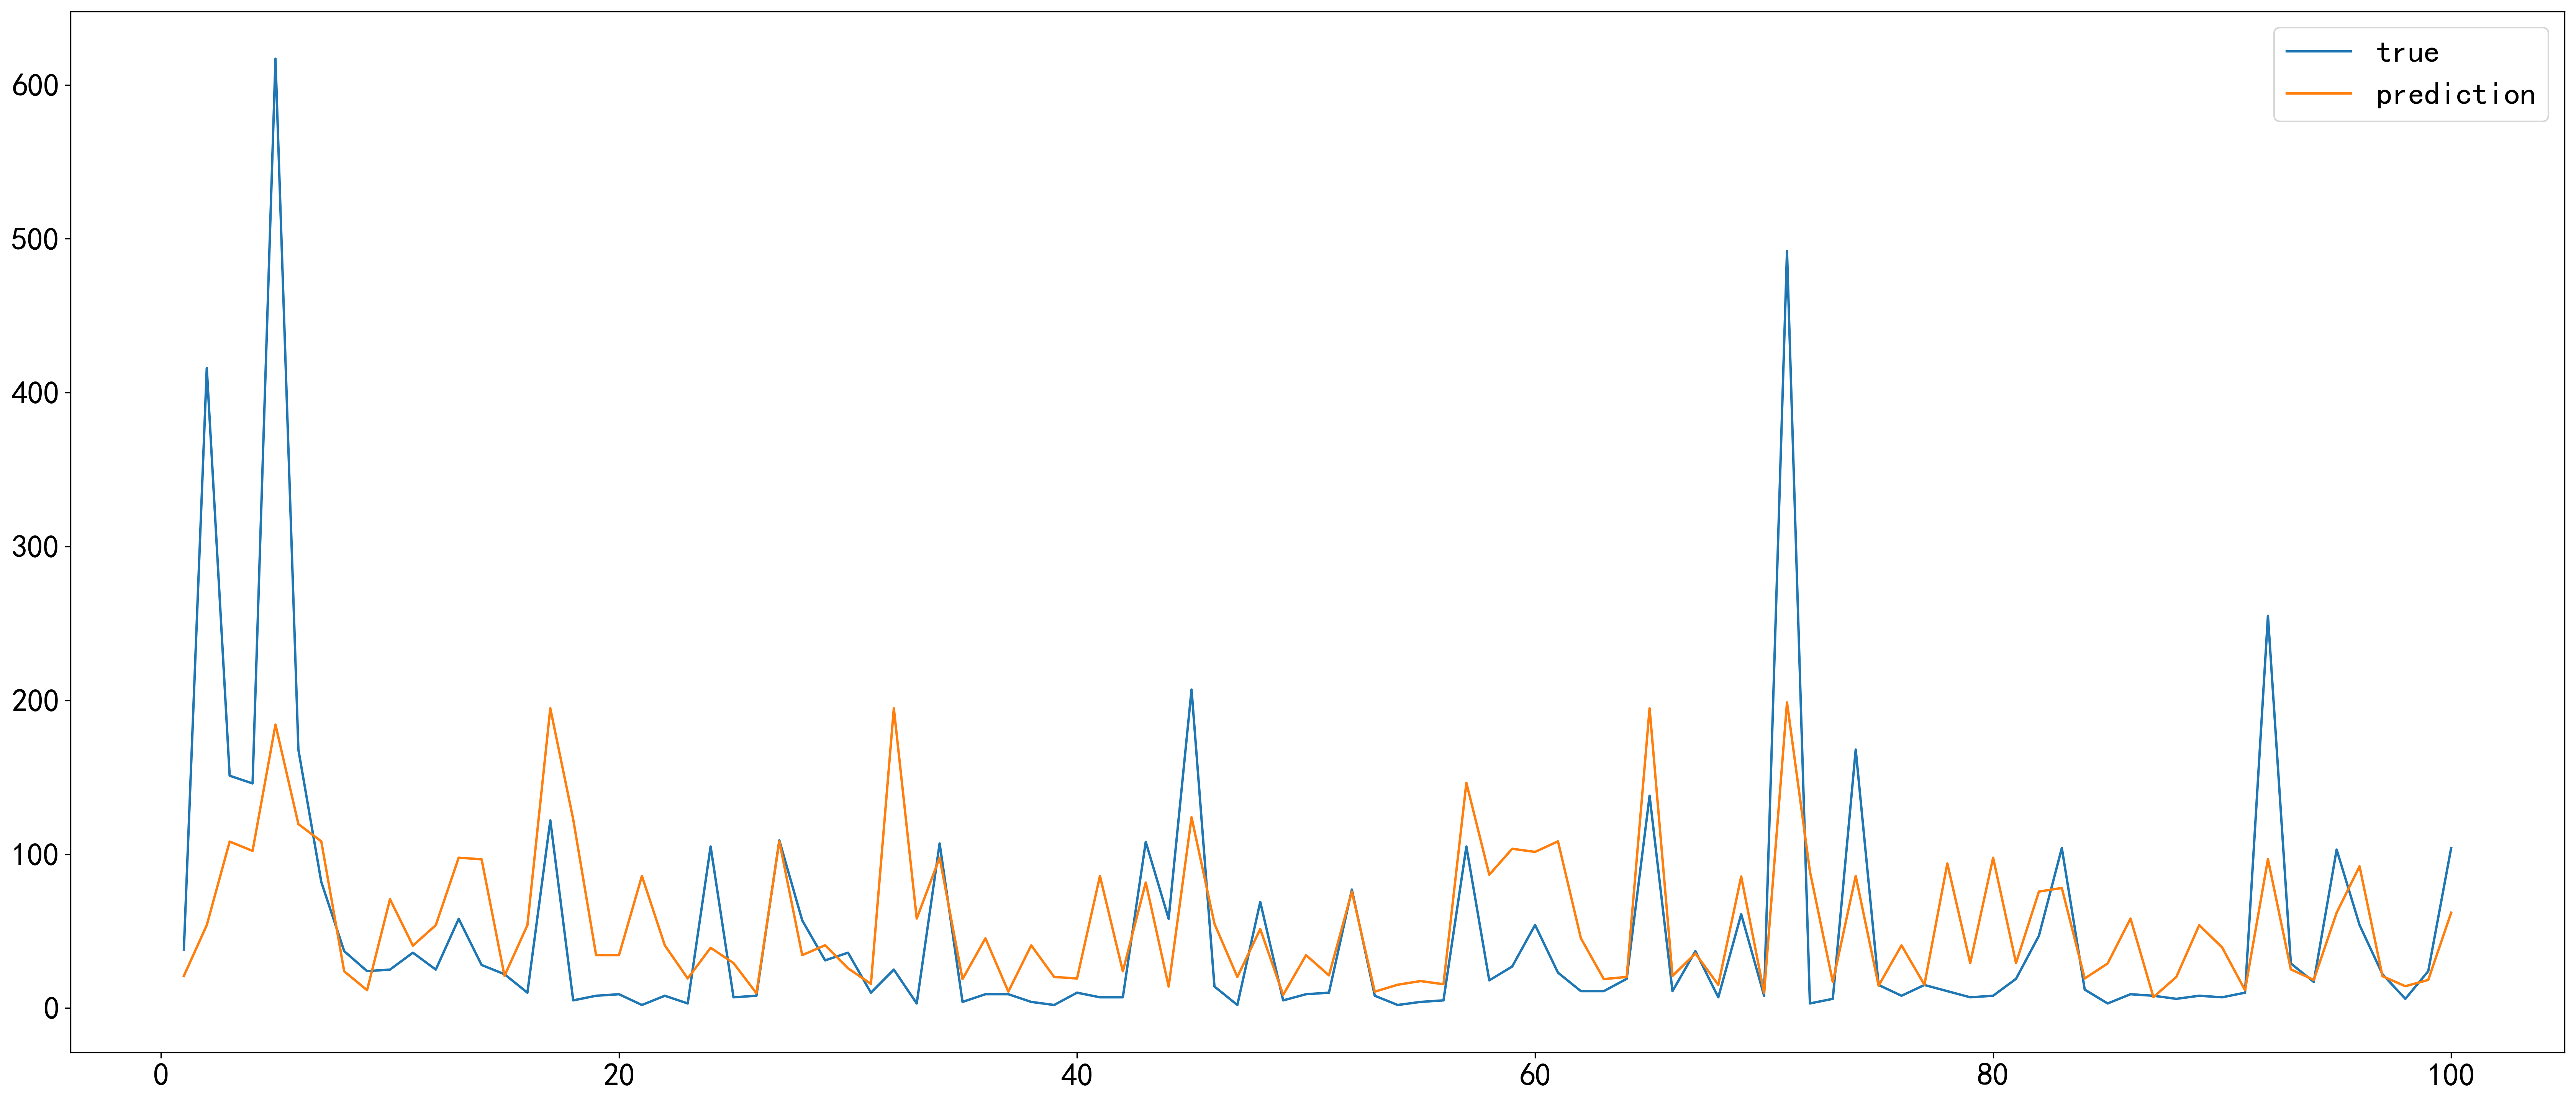

In [39]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:100],y_valid[:100])
plt.plot(x_axis[:100],s[:100])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

model_101.pkl
model_102.pkl
model_103.pkl
model_105.pkl


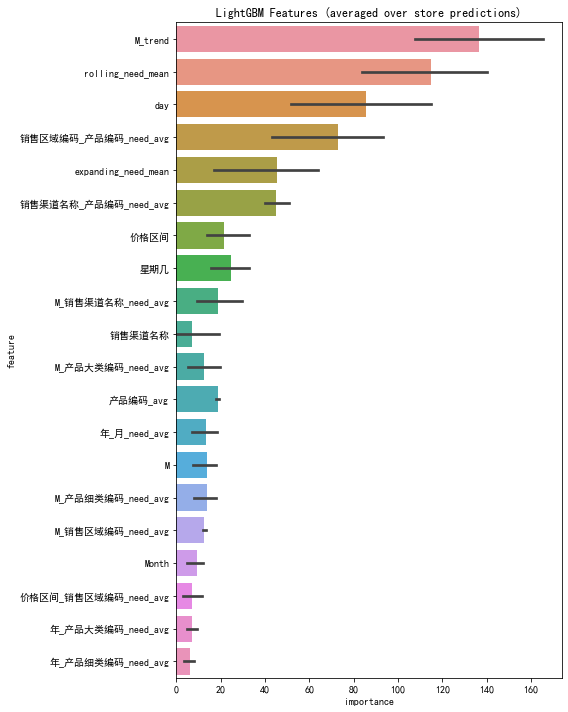

In [40]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != '订单需求量']
# print(features)
for filename in os.listdir('./models'):
    print(filename)
    if 'model' in filename:
        # load model
        model = joblib.load("models/"+filename) 
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
        del model
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# 读取待预测文件整理结果·

In [41]:
result=[]
for v in eval_preds:
    if v<0:
        result.append(0)  #预测值里有负值，这是不可能的，所有我们用0来代表异常值，
    else:
        result.append(round(v,0))

In [42]:
## d读取之前构造好的19年1月数据：
df_sub= pd.read_csv('../以周粒度预测/data/构造19_01data.csv')
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,价格区间,每月时间段,season_bm,星期几,is_workday,M
0,2018-12-01,101,21795,306,407,0,10,2018,12,1,1,0,4,0,3,5,0,40
1,2018-12-01,101,21467,306,407,0,10,2018,12,1,1,0,5,0,3,5,0,40
2,2018-12-01,101,21619,306,402,0,3,2018,12,1,1,0,0,0,3,5,0,40
3,2018-12-01,101,20215,302,408,0,3,2018,12,1,1,0,6,0,3,5,0,40
4,2018-12-01,101,21330,303,401,0,2,2018,12,1,1,0,6,0,3,5,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230182,2019-01-31,102,20176,307,403,1,0,2019,1,31,0,0,2,2,3,3,1,41
230183,2019-01-31,105,21089,306,407,1,0,2019,1,31,0,0,2,2,3,3,1,41
230184,2019-01-31,105,21105,308,404,0,0,2019,1,31,0,0,5,2,3,3,1,41
230185,2019-01-31,101,20859,306,407,0,0,2019,1,31,0,0,0,2,3,3,1,41


### 提取点真值与预测值对比一下：

In [43]:
trues = list(df_sub[df_sub['订单日期']<=pd.Timestamp("2018-12-20").strftime("%Y-%m-%d")]['订单需求量'])
trues 

[10,
 10,
 3,
 3,
 2,
 7,
 5,
 65,
 37,
 43,
 12,
 18,
 206,
 70,
 4,
 377,
 26,
 4,
 54,
 3,
 2,
 11,
 12,
 8,
 23,
 3,
 5,
 4,
 14,
 12,
 10,
 9,
 25,
 18,
 105,
 258,
 11,
 41,
 109,
 19,
 75,
 177,
 15,
 13,
 44,
 31,
 27,
 43,
 53,
 59,
 12,
 25,
 304,
 106,
 110,
 10,
 43,
 9,
 153,
 403,
 14,
 11,
 12,
 34,
 18,
 37,
 125,
 28,
 9,
 17,
 36,
 11,
 416,
 151,
 41,
 141,
 52,
 7,
 4,
 7,
 10,
 5,
 9,
 2,
 3,
 36,
 155,
 9,
 252,
 53,
 94,
 25,
 207,
 186,
 18,
 203,
 26,
 9,
 10,
 5,
 2,
 28,
 4,
 4,
 9,
 5,
 3,
 7,
 10,
 5,
 501,
 25,
 8,
 9,
 9,
 8,
 8,
 56,
 3,
 208,
 57,
 3,
 7,
 8,
 6,
 9,
 3,
 9,
 147,
 8,
 307,
 302,
 156,
 403,
 106,
 51,
 107,
 8,
 157,
 14,
 2,
 71,
 17,
 6,
 10,
 5,
 8,
 9,
 3,
 6,
 6,
 12,
 2,
 3,
 5,
 13,
 2,
 10,
 201,
 7,
 2,
 13,
 11,
 53,
 26,
 64,
 21,
 55,
 13,
 22,
 32,
 58,
 107,
 124,
 30,
 28,
 407,
 29,
 42,
 58,
 181,
 129,
 120,
 17,
 130,
 86,
 221,
 68,
 68,
 18,
 17,
 73,
 183,
 13,
 141,
 24,
 48,
 66,
 28,
 101,
 302,
 37,
 65,
 77,


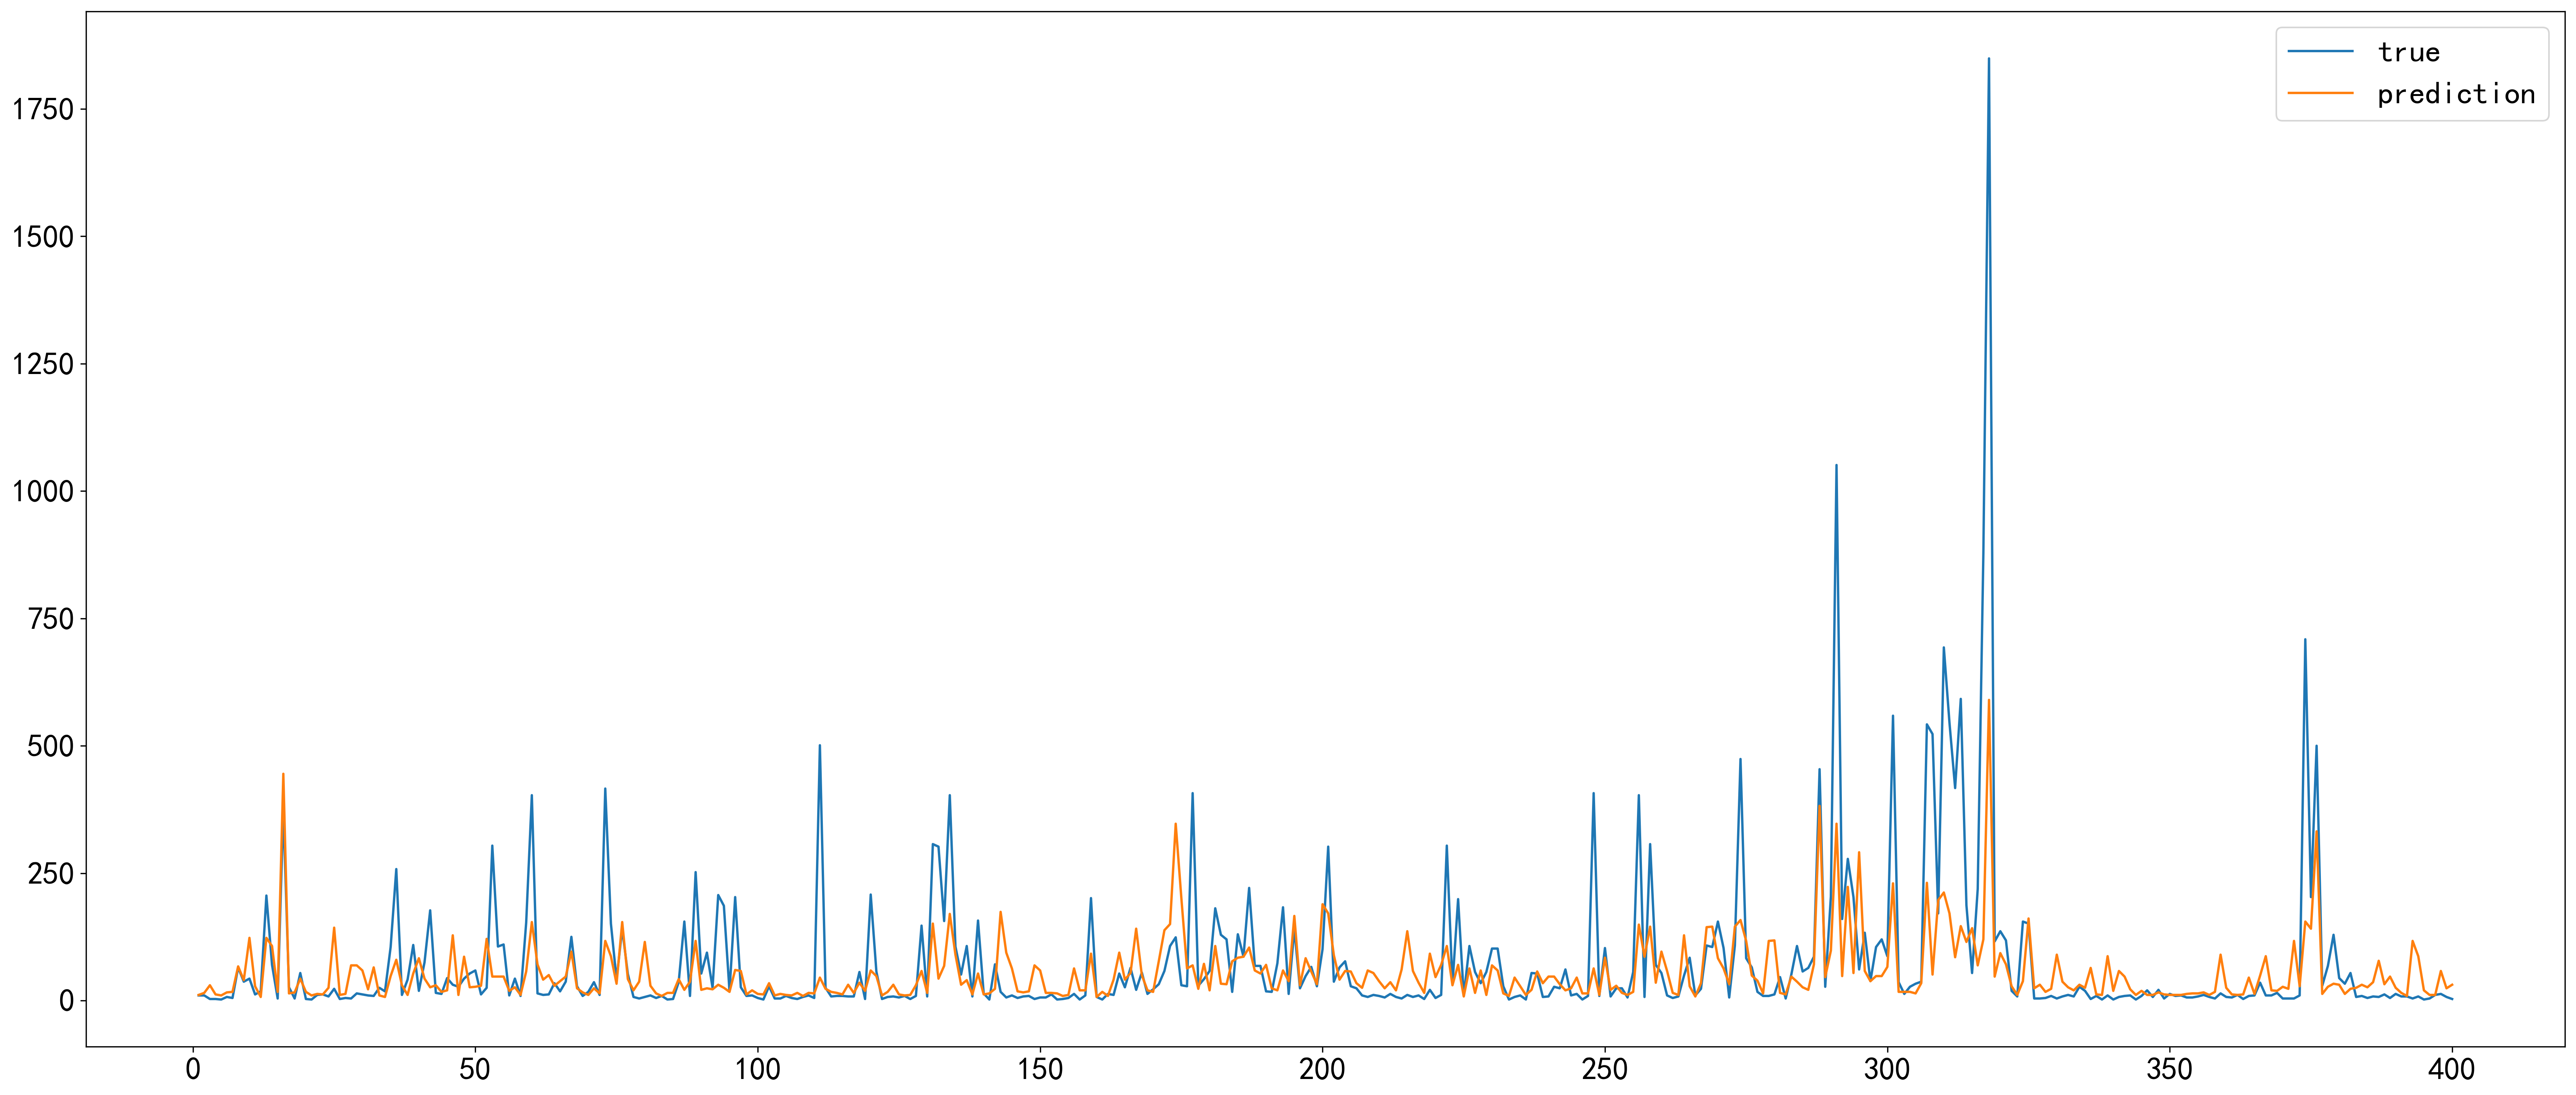

In [44]:
pres = result[:len(trues)]
pres


x_axis=np.linspace(1,len(trues),len(trues))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:400],trues[:400])
plt.plot(x_axis[:400],pres[:400])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

In [45]:
# 将预测的各产品一月需求量值进行替换
df_sub['订单需求量'] = result  #把预测的订单需求量替换
df_sub.to_csv('output/构造的1月数据预测结果.csv',index=False)
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,价格区间,每月时间段,season_bm,星期几,is_workday,M
0,2018-12-01,101,21795,306,407,0,11.0,2018,12,1,1,0,4,0,3,5,0,40
1,2018-12-01,101,21467,306,407,0,15.0,2018,12,1,1,0,5,0,3,5,0,40
2,2018-12-01,101,21619,306,402,0,30.0,2018,12,1,1,0,0,0,3,5,0,40
3,2018-12-01,101,20215,302,408,0,12.0,2018,12,1,1,0,6,0,3,5,0,40
4,2018-12-01,101,21330,303,401,0,10.0,2018,12,1,1,0,6,0,3,5,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230182,2019-01-31,102,20176,307,403,1,17.0,2019,1,31,0,0,2,2,3,3,1,41
230183,2019-01-31,105,21089,306,407,1,21.0,2019,1,31,0,0,2,2,3,3,1,41
230184,2019-01-31,105,21105,308,404,0,11.0,2019,1,31,0,0,5,2,3,3,1,41
230185,2019-01-31,101,20859,306,407,0,52.0,2019,1,31,0,0,0,2,3,3,1,41


In [46]:
result_df1=df_sub.loc[df_sub['M']>=41]  #定位到19年1月的数据
result_df1
result_df = result_df1[['M','销售区域编码','产品编码','产品大类编码','产品细类编码','订单需求量']]  #筛选出需要的列

result_df

,M,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量
71808,41,101,21934,306,407,10.0
71809,41,103,20518,305,412,12.0
71810,41,103,20548,303,401,11.0
71811,41,102,20318,306,407,7.0
71812,41,105,21938,302,408,11.0
...,...,...,...,...,...,...
230182,41,102,20176,307,403,17.0
230183,41,105,21089,306,407,21.0
230184,41,105,21105,308,404,11.0
230185,41,101,20859,306,407,52.0


In [47]:
#制作透视表得到所有产品19年1月的需求量
result_df = pd.pivot_table(result_df, index=['销售区域编码','产品大类编码','产品细类编码','产品编码'], columns='M',
                                  values='订单需求量', aggfunc=np.sum,fill_value=1).reset_index()
result_df

M,销售区域编码,产品大类编码,产品细类编码,产品编码,41
0,101,301,405,20003,494
1,101,301,405,20027,280
2,101,301,405,20085,295
3,101,301,405,20219,338
4,101,301,405,20270,265
...,...,...,...,...,...
5104,105,308,404,21981,341
5105,105,308,404,22005,465
5106,105,308,404,22018,341
5107,105,308,404,22023,384


In [48]:

# result_df=result_df[['销售区域编码','产品大类编码','产品细类编码','产品编码','41']]
# # result_df.columns=['销售区域编码','产品大类编码','产品细类编码','产品编码','一月需求量']
# result_df 

In [49]:
# 读入predict_sku0.csv，进行匹配汇总，得到结果
# 读入predict_sku0.csv，进行匹配汇总，predict_sku0中的产品的1月需求量：
predict_df = pd.read_csv("../B题-全部数据//predict_sku1.csv")
predict_df.columns =['销售区域编码','产品编码','产品大类编码','产品细类编码',]
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [50]:
s=pd.merge(predict_df,result_df,how='inner')

s.columns =['销售区域编码','产品编码','产品大类编码','产品细类编码','一月需求量']
s

,销售区域编码,产品编码,产品大类编码,产品细类编码,一月需求量
0,101,20002,303,406,308
1,101,20003,301,405,494
2,101,20006,307,403,448
3,101,20014,307,403,895
4,101,20016,303,401,307
...,...,...,...,...,...
2182,105,22059,305,412,384
2183,105,22066,307,403,1656
2184,105,22072,305,412,864
2185,105,22083,303,401,1005
